In [2]:
## No elimine esta celda, ya que permite actualizar los archivos .py
## sin tener que reiniciar el Kernel de Jupyter.
%load_ext autoreload
%autoreload 2

from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
import time
from torchinfo import summary
import timm
from train import *
from torch.utils.data import DataLoader, Subset
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
len(timm.list_models())

timm.list_models("efficientnet*")

['efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_blur_b0',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_h_b5',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnet_x_b3',
 'efficientnet_x_b5',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl']

In [3]:
   
class Transforms:
    def __init__(self, transform: transforms.Compose):
        self.transform = transform

    def __call__(self, image):
        if not isinstance(image, Image.Image):  # Verifica que sea una instancia de PIL.Image
            raise TypeError("La entrada debe ser una imagen PIL.")
        return self.transform(image)


# Transformaciones para el conjunto de entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona la imagen
    transforms.ToTensor(),  # Convierte la imagen a un tensor (normaliza a rango [0, 1])
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalización estándar
])

# Transformaciones para el conjunto de validación
validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_data = ImageFolder(
    "house_plant_species/train",
    transform=Transforms(train_transforms),
)
validation_data = ImageFolder(
    "house_plant_species/validation",
    transform=Transforms(validation_transforms),
)

print(f"Elementos en Entrenamiento: {len(train_data)}")
print(f"Elementos en Validación: {len(validation_data)}")

Elementos en Entrenamiento: 10835
Elementos en Validación: 2736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([3, 256, 256])


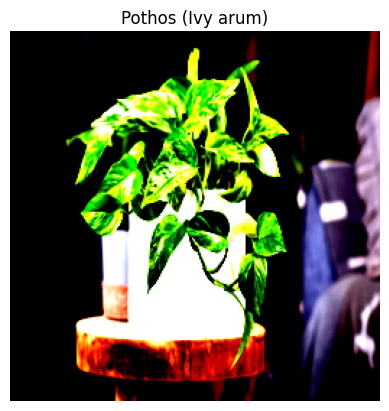

In [4]:
idx = np.random.randint(0, len(train_data))


## Es importante cambiar el orden de los canales para poder mostrar la imagen...
def plot_images(idx, data):
    plt.imshow(data[idx][0].permute(1, 2, 0))
    class_label = data[idx][1]
    plt.title(data.classes[class_label])
    plt.axis("off")
    print(data[idx][0].shape)

plot_images(idx, train_data)

In [5]:

# Función para realizar un muestreo proporcional
def proportional_sample_indices(dataset, proportion):
    """
    Realiza un muestreo proporcional de un dataset.
    Args:
        dataset: Dataset de tipo ImageFolder.
        proportion: Proporción del dataset original a incluir (0.0 - 1.0).
    Returns:
        numpy array con los índices muestreados.
    """
    # Crear un DataFrame con las rutas y etiquetas de las imágenes
    data = pd.DataFrame({
        'path': [item[0] for item in dataset.samples],
        'label': [item[1] for item in dataset.samples]
    })

    # Calcular el número de muestras proporcional para cada clase
    sampled_data = data.groupby('label').apply(
        lambda x: x.sample(frac=proportion, random_state=42, replace=False)
    ).reset_index(drop=True)

    # Obtener los índices correspondientes en el dataset original
    sampled_indices = sampled_data.index.to_numpy()
    return sampled_indices


# Determinar cuántas clases tiene el problema
num_classes = len(train_data.classes)
print(f"Número de clases en el problema: {num_classes}")

# Definir proporción de datos a tomar
proportion = 0.5  # El 30% de los datos originales

# Crear datasets proporcionalmente reducidos
train_sample_indices = proportional_sample_indices(train_data, proportion)
val_sample_indices = proportional_sample_indices(validation_data, proportion)

# Crear Subsets a partir de los índices
proportional_train_data = Subset(train_data, train_sample_indices)
proportional_validation_data = Subset(validation_data, val_sample_indices)

# Visualizar estadísticas
print(f"Tamaño del dataset proporcional de entrenamiento: {len(proportional_train_data)}")
print(f"Tamaño del dataset proporcional de validación: {len(proportional_validation_data)}")


Número de clases en el problema: 47
Tamaño del dataset proporcional de entrenamiento: 5416
Tamaño del dataset proporcional de validación: 1367


/tmp/ipykernel_3660/3024373191.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('label').apply(
/tmp/ipykernel_3660/3024373191.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('label').apply(


In [5]:
import torchvision.models as models
import torch.nn as nn

class Alexnet(nn.Module):
    def __init__(self, backbone, output_dim, frozen=False):
        super().__init__()
        self.backbone = backbone
        # Reemplazar la última capa con Linear (mejor que LazyLinear si conoces las dimensiones)
        self.backbone.classifier[6] = nn.Linear(4096, output_dim)

        if frozen:
            # Congela todas las capas convolucionales
            for param in self.backbone.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

# Número de clases en el problema
num_classes = len(train_data.classes)

# Instanciar el modelo con pesos preentrenados
frozen_alexnet = Alexnet(
    backbone=models.alexnet(weights="IMAGENET1K_V1"),
    output_dim=num_classes,
    frozen=True,  # Cambia a False para permitir el fine-tuning
).to(device)

# Resumen del modelo
from torchinfo import summary
summary(frozen_alexnet, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
Alexnet                                  [1, 47]                   --
├─AlexNet: 1-1                           [1, 47]                   --
│    └─Sequential: 2-1                   [1, 256, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 63, 63]           (23,296)
│    │    └─ReLU: 3-2                    [1, 64, 63, 63]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 31, 31]           --
│    │    └─Conv2d: 3-4                  [1, 192, 31, 31]          (307,392)
│    │    └─ReLU: 3-5                    [1, 192, 31, 31]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 15, 15]          --
│    │    └─Conv2d: 3-7                  [1, 384, 15, 15]          (663,936)
│    │    └─ReLU: 3-8                    [1, 384, 15, 15]          --
│    │    └─Conv2d: 3-9                  [1, 256, 15, 15]          (884,992)
│    │    └─ReLU: 3-10                   [1, 256, 15, 15] 

In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 50,
}

# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="alexnet",
    model=frozen_alexnet,
    training_params=training_params,
    num_classes=num_classes
)

# Guardar el modelo entrenado
torch.save(trained_model.state_dict(), f"alexnet_end_model.pth")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: benjaminrromo (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/50 - Time: 98.22s - Train Loss: 2.1409, Train F1: 0.4262 - Validation Loss: 1.5137, Validation F1: 0.5837
Epoch: 2/50 - Time: 98.23s - Train Loss: 1.5726, Train F1: 0.5704 - Validation Loss: 1.4268, Validation F1: 0.6181
Epoch: 3/50 - Time: 95.81s - Train Loss: 1.4095, Train F1: 0.6164 - Validation Loss: 1.3395, Validation F1: 0.6396
Epoch: 4/50 - Time: 94.53s - Train Loss: 1.2676, Train F1: 0.6540 - Validation Loss: 1.2376, Validation F1: 0.6703
Epoch: 5/50 - Time: 95.84s - Train Loss: 1.1596, Train F1: 0.6836 - Validation Loss: 1.2367, Validation F1: 0.6725
Epoch: 6/50 - Time: 99.56s - Train Loss: 1.1171, Train F1: 0.6998 - Validation Loss: 1.2597, Validation F1: 0.6572
Epoch: 7/50 - Time: 94.53s - Train Loss: 1.0822, Train F1: 0.7113 - Validation Loss: 1.2905, Validation F1: 0.6590
Epoch: 8/50 - Time: 98.05s - Train Loss: 1.0200, Train F1: 0.7286 - Validation Loss: 1.3525, Validation F1: 0.6700
Epoch: 9/50 - Time: 96.86s - Train Loss: 0.9834, Train F1: 0.7422 - Validation L

elapsed_time,▇▇▄▂▄▂▇▅▃▄▃▇▄▄▆▁█▄▁▃▂▄▃▅▂▃▆▁▂▆▆▇▁▃▄▃▅▃▂▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_f1,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▃▄▆▆▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇▇▇▇█▇
val_loss,▃▃▁▁▁▂▁▂▃▂▃▃▃▂▃▄▄▄▄▅▅▄▅▅▄▆▇▅▇▅▇▆█▇▆█▆▇▇▇
elapsed_time,97.44021
epoch,50
train_f1,0.90937
train_loss,0.45484
val_f1,0.69956


In [5]:
len(timm.list_models())

timm.list_models("*")

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 10,
}
sample_image, _ = train_data[0]  # Accede al primer elemento del dataset
in_channels = sample_image.shape[0]  # Dimensión del canal (e.g., 3 para RGB)
print(f"Number of input channels: {in_channels}")
# Dataset (asegúrate de definir correctamente `train_data` y `val_data`)
num_classes = len(train_data.classes)
# Crear el modelo usando timm
# Crear el modelo especificando los canales de entrada
model_resnet34 = timm.create_model(
    "resnet18",
    pretrained=True,
    num_classes=num_classes,
    in_chans=in_channels,
)
# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="resnet18",
    model=model_resnet34,
    training_params=training_params,
    num_classes=num_classes
)

Number of input channels: 3


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: benjaminrromo (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/10 - Time: 118.01s - Train Loss: 1.4298, Train F1: 0.6257 - Validation Loss: 0.7754, Validation F1: 0.7829
Epoch: 2/10 - Time: 120.29s - Train Loss: 0.4092, Train F1: 0.8815 - Validation Loss: 0.5201, Validation F1: 0.8480
Epoch: 3/10 - Time: 111.37s - Train Loss: 0.2192, Train F1: 0.9341 - Validation Loss: 0.6428, Validation F1: 0.8235
Epoch: 4/10 - Time: 106.52s - Train Loss: 0.1516, Train F1: 0.9527 - Validation Loss: 0.5269, Validation F1: 0.8542
Epoch: 5/10 - Time: 114.09s - Train Loss: 0.0946, Train F1: 0.9719 - Validation Loss: 0.6226, Validation F1: 0.8432
Epoch: 6/10 - Time: 106.09s - Train Loss: 0.0863, Train F1: 0.9735 - Validation Loss: 0.6398, Validation F1: 0.8417
Epoch: 7/10 - Time: 103.61s - Train Loss: 0.0684, Train F1: 0.9769 - Validation Loss: 0.4711, Validation F1: 0.8805
Epoch: 8/10 - Time: 103.00s - Train Loss: 0.0577, Train F1: 0.9828 - Validation Loss: 0.5660, Validation F1: 0.8553
